## Training

training a 3D U-Net model

In [1]:
import os
import numpy as np
#import tensorflow as tf
import torch
from torch import nn
from matplotlib import pyplot as plt
import glob
import random
import pandas as pd

#### **Class Weight Calculation**: (not used atm)
Class weights are calculated based on the distribution of each class (four) in the training data. These weights are used for balancing the loss (dice loss in our case) function during training.

(we can also assign equal weights: 0.25, 0.25, 0.25, 0.25)

#### **Image Generators**:
Image generators for training and validation sets are defined using the custom data loader.

In [2]:
from custom_generator import imageLoader

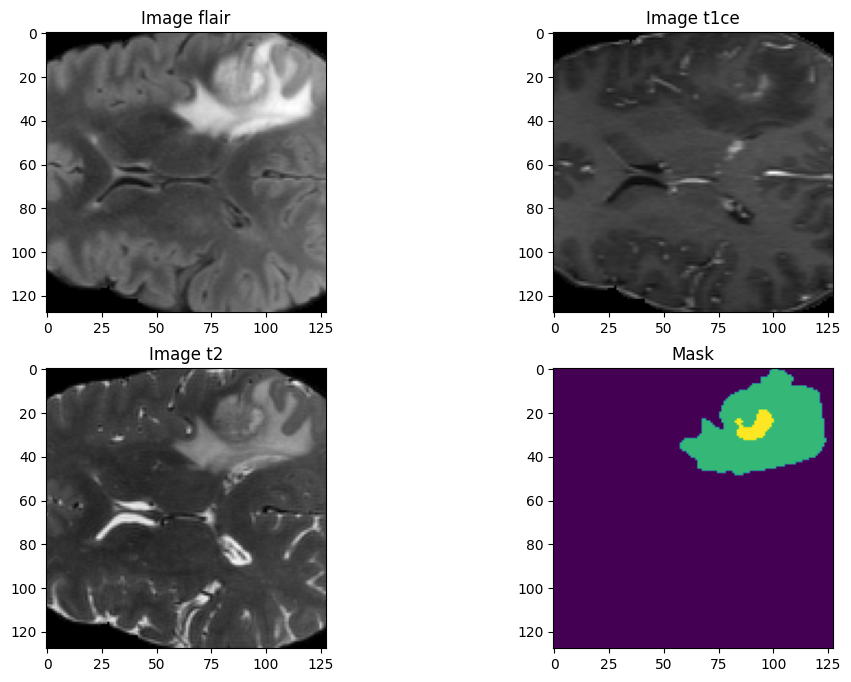

In [59]:
train_img_dir = "BraTS2021_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2021_TrainingData/input_data_128/train/masks/"

val_img_dir = "BraTS2021_TrainingData/input_data_128/val/images/"
val_mask_dir = "BraTS2021_TrainingData/input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator
for img, msk in train_img_datagen:
    break  # Break after the first batch

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

# n_slice=random.randint(0, test_mask.shape[2])
n_slice = 70

# print(img.shape) --> torch.Size([2, 192, 192, 128, 3])
# print(test_img.shape) --> torch.Size([192, 192, 128, 3])

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
print(len(train_img_datagen))
print(len(train_mask_list))
print(len(val_img_datagen))
print(len(val_mask_list))

**Loss Function, Metrics, and Optimizer**:
- Multiclass Dice Loss is defined as the loss functions.
- Metrics such as accuracy and IOU (Intersection over Union) are used for evaluation.
- Adam optimizer is utilized for optimization.

In [6]:
class MultiClassDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(MultiClassDiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # inputs: [batch_size, num_classes, ...]
        # targets: [batch_size, num_classes, ...]

        dice_per_class = []
        for class_idx in range(inputs.size(1)):  # Iterate over classes
            class_inputs = inputs[:, class_idx, ...]
            #plt.imshow(class_inputs.detach().numpy()[:,70,:])
            class_targets = targets[:, class_idx, ...]
            
            # Dice Loss for each class separately
            intersection = (class_inputs * class_targets).sum()
            dice = (2. * intersection + smooth) / (class_inputs.sum() + class_targets.sum() + smooth)
            dice_per_class.append(dice)

        # Average Dice Loss across all classes
        mean_dice_loss = torch.mean(torch.stack(dice_per_class))
        return 1 - mean_dice_loss
    

class MultiIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(MultiIoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
          
        IoU_per_class = []
        for class_idx in range(inputs.size(1)):
            class_inputs = inputs[:, class_idx, ...]
            class_targets = targets[:, class_idx, ...]
        
            intersection = (class_inputs * class_targets).sum() # True Positive count
            total = (class_inputs + class_targets).sum()
            union = total - intersection  # mutually inclusive area of all labels & predictions 
        
            IoU = (intersection + smooth)/(union + smooth)
            IoU_per_class.append(IoU)

        mean_IoU_loss = torch.mean(torch.stack(IoU_per_class))
                
        return mean_IoU_loss # actually it should be 1-mean_IoU_loss but i am using it as an accuracy measure

### Model Definition and Initialization

In [3]:
from exampleUnet import SA_UNet_8x8
model = SA_UNet_8x8()

In [8]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
LR = 0.0001
NUM_EPOCHS = 35
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

multi_dice = MultiClassDiceLoss()
multi_IoU = MultiIoULoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


### Training Loop

In [ ]:
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    
    for images, masks in train_img_datagen:
        images = images.float().to(device=DEVICE)
        masks = masks.float().to(device=DEVICE)
        masks = torch.transpose(torch.transpose(torch.transpose(masks, 1, -1), 2, -1), 2, -2)
        optimizer.zero_grad()
        preds = model(torch.transpose(torch.transpose(torch.transpose(images, 1, -1), 2, -1), 2, -2))

        loss = multi_dice(preds,masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_accuracy += multi_IoU(preds, masks).item()
        print("accuracy:", running_accuracy)

    epoch_loss = running_loss / len(train_img_datagen)
    epoch_accuracy = running_accuracy / len(train_img_datagen)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}:")
    print(f"  Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'models/brats_Unet3d.pth')

## Validation on one sample

In [62]:
modelLoad = SA_UNet_8x8()

modelLoad.load_state_dict(torch.load('models/brats_Unet3d.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [63]:
for imgs, msks in val_img_datagen:
    break

#print(imgs.shape, msks.shape) # --> torch.Size([2, 128, 128, 128, 3]) torch.Size([2, 128, 128, 128, 4])

img_num = random.randint(0, imgs.size(0)-1)
val_img = imgs[img_num].unsqueeze(0)
val_msk = msks[img_num].unsqueeze(0)

#print(val_img.shape, val_msk.shape) # --> torch.Size([1, 128, 128, 128, 3]) torch.Size([1, 128, 128, 128, 4])

In [64]:
val_pred = modelLoad(torch.transpose(torch.transpose(torch.transpose(val_img.float(), 1, -1), 2, -1), 2, -2))
#print(val_pred.shape) # --> torch.Size([1, 4, 128, 128, 128])

In [65]:
val_pred = val_pred[0] # shape = torch.Size([4, 128, 128, 128])
val_pred = torch.transpose(torch.transpose(torch.transpose(val_pred, 0, -1), 0, 2), 1, 2) # shape = torch.Size([128, 128, 128, 4])
val_msk = val_msk[0] # shape = torch.Size([128, 128, 128, 4])

In [66]:
val_img = val_img[0]
val_img = val_img.cpu().numpy()

In [67]:
val_pred = val_pred.cpu().detach().numpy()
val_msk = val_msk.cpu().numpy()

val_msk=np.argmax(val_msk, axis=3)
val_pred = np.argmax(val_pred, axis=3)

In [69]:
val, counts = np.unique(val_pred, return_counts=True)
print('prediction', val, counts)

val, counts = np.unique(val_msk, return_counts=True)
print('mask', val, counts)

prediction [0 1 2 3] [1787156   35738  206943   67315]
mask [0 1 2 3] [1911605   20623  128007   36917]


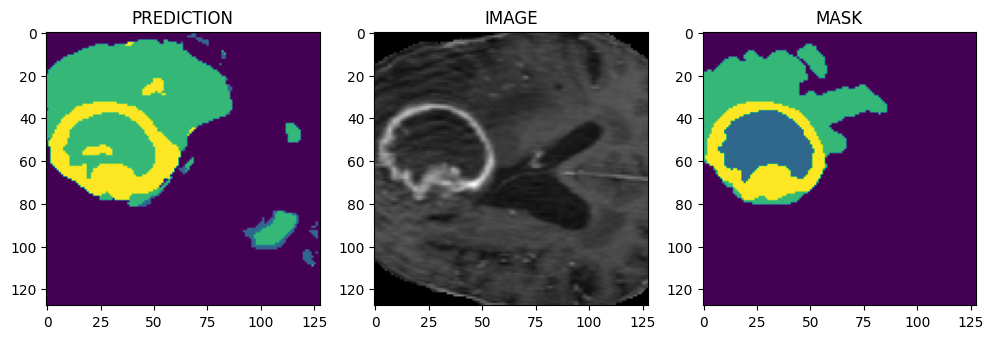

In [74]:
plt.figure(figsize=(12,6))

slice = 70

plt.subplot(131)
plt.title('PREDICTION')
plt.imshow(val_pred[:,:,70])
plt.subplot(132)
plt.title('IMAGE')
plt.imshow(val_img[:,:,70,1], cmap='gray')
plt.subplot(133)
plt.title('MASK')
plt.imshow(val_msk[:,:,70])

In [ ]:
with torch.no_grad():
    test_loss = 0
    test_acc = 0

    for images, masks in val_img_datagen:
        images = images.float().to(device=DEVICE)
        labels = masks.float().to(device=DEVICE)
        masks = torch.transpose(torch.transpose(torch.transpose(masks, 1, -1), 2, -1), 2, -2)

        preds = modelLoad(torch.transpose(torch.transpose(torch.transpose(images, 1, -1), 2, -1), 2, -2))

        loss = multi_dice(preds,masks)
        test_loss += loss.item()

        test_acc += multi_IoU(preds, masks).item()
        print('accuracy',test_acc)

    test_loss /= len(val_img_datagen)
    test_acc /= len(val_img_datagen)

print('test loss:', test_loss)
print('test accuracy:', test_acc)